Data Quality Report


Missing Data Analysis:
                           Missing Count  Missing Percentage
repo                                   0                0.00
lang                                   0                0.00
build_system                           0                0.00
test_framework                         0                0.00
ci_service                             0                0.00
image_tag                              0                0.00
failed_commit                          0                0.00
passed_commit                          0                0.00
time_to_fix_hours                      0                0.00
classification_code                   17                0.67
classification_test                   17                0.67
classification_build                  17                0.67
exceptions                             0                0.00
failed_tests                        1226               48.48
num_tests_failed                       0

<Figure size 1200x600 with 0 Axes>

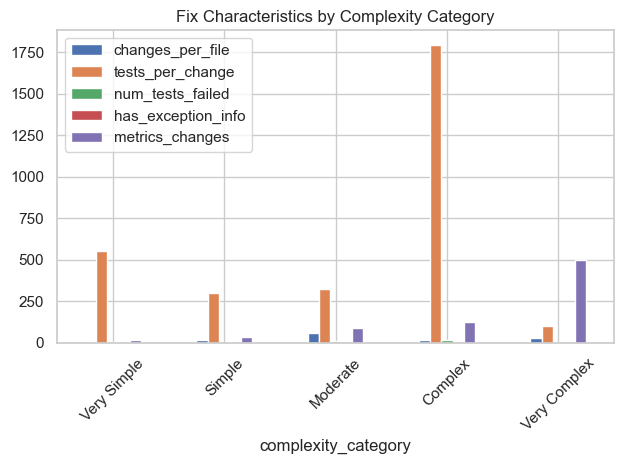

<Figure size 1000x600 with 0 Axes>

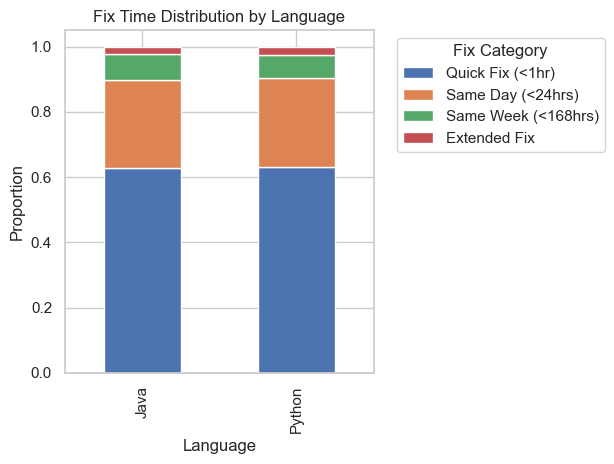

Statistical Tests


Language Comparison T-Test:
t-statistic: 1.0291
p-value: 0.3035

Exception Category ANOVA:
F-statistic: 8.0860
p-value: 0.0000

Metric Correlations:
                           time_to_fix_hours  metrics_additions  \
time_to_fix_hours                      1.000              0.279   
metrics_additions                      0.279              1.000   
metrics_deletions                      0.126              0.196   
metrics_changes                        0.259              0.758   
metrics_num_files_changed              0.280              0.677   

                           metrics_deletions  metrics_changes  \
time_to_fix_hours                      0.126            0.259   
metrics_additions                      0.196            0.758   
metrics_deletions                      1.000            0.788   
metrics_changes                        0.788            1.000   
metrics_num_files_changed              0.254            0.594   

                           metrics_nu

In [1]:
# Notebooks/artifact-data-analysis-1.ipynb

# Cell 1: Import Libraries and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
from datetime import datetime
import itertools
from scipy.stats import spearmanr, ttest_ind, f_oneway

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
warnings.filterwarnings('ignore')

# Set seaborn style
sns.set(style='whitegrid', context='notebook', palette='deep')
%matplotlib inline

# Cell 2: Data Loading and Initial Cleaning Functions
def load_and_clean_data(file_path):
    """
    Load the data and perform initial cleaning steps.
    """
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Convert timestamps to datetime
    df['failed_commit'] = pd.to_datetime(df['failed_commit'])
    df['passed_commit'] = pd.to_datetime(df['passed_commit'])
    
    # Ensure numerical columns are properly typed
    numerical_cols = ['time_to_fix_hours', 'num_tests_failed', 'num_tests_run',
                     'metrics_additions', 'metrics_deletions', 'metrics_changes',
                     'metrics_num_files_changed']
    
    for col in numerical_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    return df

def process_missing_data(df):
    """
    Handle missing values while preserving data integrity.
    """
    # Create copy to avoid modifying original
    df_processed = df.copy()
    
    # Handle missing categorical data
    df_processed['test_framework'] = df_processed['test_framework'].fillna('Unknown')
    df_processed['build_system'] = df_processed['build_system'].fillna('Unknown')
    
    # Clean exceptions data
    df_processed['exceptions'] = df_processed['exceptions'].apply(
        lambda x: str(x).strip() if pd.notnull(x) else 'No Exception Recorded'
    )
    
    # Create flags for missing data
    df_processed['has_test_info'] = df_processed['failed_tests'].notna()
    df_processed['has_exception_info'] = df_processed['exceptions'] != 'No Exception Recorded'
    
    return df_processed

def standardize_exceptions(df):
    """
    Standardize exception categories and group similar exceptions.
    """
    # Exception category mapping
    exception_mapping = {
        'RuntimeException': 'Runtime',
        'IllegalStateException': 'State',
        'IllegalArgumentException': 'Arguments',
        'AssertionError': 'Assertion',
        'ComparisonFailure': 'Assertion',
        'NullPointerException': 'Null Reference',
        'ClassNotFoundException': 'Class Loading',
        'IOException': 'IO',
        'FileNotFoundException': 'IO'
    }
    
    # Split multiple exceptions and take the first one as primary
    df['primary_exception'] = df['exceptions'].str.split(';').str[0]
    
    # Map to categories
    df['exception_category'] = df['primary_exception'].map(exception_mapping)
    df['exception_category'].fillna('Other', inplace=True)
    
    return df

def analyze_fix_times(df):
    """
    Analyze and categorize fix times.
    """
    # Create time buckets
    df['fix_time_category'] = pd.cut(
        df['time_to_fix_hours'],
        bins=[0, 1, 24, 168, float('inf')],
        labels=['Quick Fix (<1hr)', 'Same Day (<24hrs)', 
                'Same Week (<168hrs)', 'Extended Fix']
    )
    
    # Calculate IQR for outlier detection
    Q1 = df['time_to_fix_hours'].quantile(0.25)
    Q3 = df['time_to_fix_hours'].quantile(0.75)
    IQR = Q3 - Q1
    df['is_outlier'] = (df['time_to_fix_hours'] > (Q3 + 1.5 * IQR)) | \
                       (df['time_to_fix_hours'] < (Q1 - 1.5 * IQR))
    
    return df

# Cell 3: Load and Process Data
# Load data
file_path = '/Users/harshil/Developer/GitHub_Repos/FailFix/Data/processed/artifact_data_table.csv'
df_raw = load_and_clean_data(file_path)

# Apply processing steps
df = process_missing_data(df_raw)
df = standardize_exceptions(df)
df = analyze_fix_times(df)

# Cell 4: Visualization Functions
def plot_fix_time_distributions(df):
    """Create visualization grid for fix time distributions."""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Overall distribution (log scale)
    sns.histplot(data=df, x='time_to_fix_hours', ax=ax1)
    ax1.set_xscale('log')
    ax1.set_title('Fix Time Distribution (Log Scale)')
    
    # By language
    sns.boxplot(data=df, x='lang', y='time_to_fix_hours', ax=ax2)
    ax2.set_yscale('log')
    ax2.set_title('Fix Times by Language')
    
    # By exception category (top 5)
    top_exceptions = df['exception_category'].value_counts().head().index
    df_top = df[df['exception_category'].isin(top_exceptions)]
    sns.boxplot(data=df_top, x='exception_category', y='time_to_fix_hours', ax=ax3)
    ax3.set_yscale('log')
    ax3.tick_params(axis='x', rotation=45)
    ax3.set_title('Fix Times by Top Exception Categories')
    
    # Time category distribution
    sns.countplot(data=df, x='fix_time_category', ax=ax4)
    ax4.tick_params(axis='x', rotation=45)
    ax4.set_title('Distribution of Fix Time Categories')
    
    plt.tight_layout()
    return fig

# Cell 5: Data Quality Report
def generate_data_quality_report(df):
    """
    Generate a comprehensive data quality report.
    """
    total_rows = len(df)
    
    # Missing data analysis
    missing_data = pd.DataFrame({
        'Missing Count': df.isnull().sum(),
        'Missing Percentage': (df.isnull().sum() / total_rows * 100).round(2)
    })
    
    # Value distributions for categorical columns
    categorical_cols = ['lang', 'build_system', 'test_framework', 'exception_category']
    value_distributions = {col: df[col].value_counts().head() for col in categorical_cols}
    
    # Numerical column statistics
    numerical_cols = ['time_to_fix_hours', 'num_tests_failed', 'num_tests_run',
                     'metrics_additions', 'metrics_deletions', 'metrics_changes']
    numerical_stats = df[numerical_cols].describe()
    
    return {
        'missing_data': missing_data,
        'value_distributions': value_distributions,
        'numerical_stats': numerical_stats
    }

quality_report = generate_data_quality_report(df)
print("Data Quality Report\n")
print("\nMissing Data Analysis:")
print(quality_report['missing_data'])
print("\nValue Distributions:")
for col, dist in quality_report['value_distributions'].items():
    print(f"\n{col}:")
    print(dist)
print("\nNumerical Statistics:")
print(quality_report['numerical_stats'])

# Cell 5: Fix Time Analysis
def analyze_fix_time_patterns(df):
    """
    Analyze patterns in fix times across different dimensions.
    """
    # Overall statistics
    overall_stats = df['time_to_fix_hours'].describe()
    
    # Fix time by language
    lang_stats = df.groupby('lang')['time_to_fix_hours'].agg(['mean', 'median', 'count'])
    
    # Fix time by exception category
    exception_stats = df.groupby('exception_category')['time_to_fix_hours'].agg(['mean', 'median', 'count'])
    
    # Time category distribution
    time_category_dist = df['fix_time_category'].value_counts()
    
    return {
        'overall_stats': overall_stats,
        'lang_stats': lang_stats,
        'exception_stats': exception_stats,
        'time_category_dist': time_category_dist
    }

fix_time_analysis = analyze_fix_time_patterns(df)
print("Fix Time Analysis\n")
print("\nOverall Statistics:")
print(fix_time_analysis['overall_stats'])
print("\nBy Programming Language:")
print(fix_time_analysis['lang_stats'])
print("\nBy Exception Category:")
print(fix_time_analysis['exception_stats'])
print("\nFix Time Category Distribution:")
print(fix_time_analysis['time_category_dist'])

# Cell 6: Repository Analysis
def analyze_repositories(df):
    """
    Analyze repository-specific patterns.
    """
    # Repository statistics
    repo_stats = df.groupby('repo').agg({
        'time_to_fix_hours': ['mean', 'median', 'count'],
        'num_tests_failed': 'mean',
        'metrics_changes': 'mean'
    }).round(2)
    
    # Filter repositories with minimum number of artifacts
    min_artifacts = 5
    repo_stats = repo_stats[repo_stats[('time_to_fix_hours', 'count')] >= min_artifacts]
    
    # Sort by average fix time
    repo_stats = repo_stats.sort_values(('time_to_fix_hours', 'mean'), ascending=False)
    
    return repo_stats

repo_analysis = analyze_repositories(df)
print("Repository Analysis\n")
print("\nTop 10 Repositories by Average Fix Time:")
print(repo_analysis.head(10))
print("\nBottom 10 Repositories by Average Fix Time:")
print(repo_analysis.tail(10))

# Cell 7: Exception Pattern Analysis
def analyze_exception_patterns(df):
    """
    Analyze patterns in exceptions and their relationship with fix times.
    """
    # Exception category frequency
    exception_freq = df['exception_category'].value_counts()
    
    # Average fix time by exception category
    exception_fix_times = df.groupby('exception_category')['time_to_fix_hours'].agg([
        'mean', 'median', 'count'
    ]).round(2)
    
    # Exception patterns by programming language
    lang_exceptions = pd.crosstab(df['lang'], df['exception_category'])
    
    return {
        'frequency': exception_freq,
        'fix_times': exception_fix_times,
        'by_language': lang_exceptions
    }

exception_analysis = analyze_exception_patterns(df)
print("Exception Pattern Analysis\n")
print("\nException Category Frequency:")
print(exception_analysis['frequency'])
print("\nFix Times by Exception Category:")
print(exception_analysis['fix_times'])
print("\nExceptions by Programming Language:")
print(exception_analysis['by_language'])

# Cell 8: Advanced Analysis Functions
def analyze_fix_complexity(df):
    """Analyze what makes fixes complex"""
    # Create composite metrics
    df['changes_per_file'] = df['metrics_changes'] / df['metrics_num_files_changed'].clip(lower=1)
    df['tests_per_change'] = df['num_tests_run'] / df['metrics_changes'].clip(lower=1)
    
    # Categorize fixes
    df['complexity_category'] = pd.qcut(
        df['time_to_fix_hours'], 
        q=5,
        labels=['Very Simple', 'Simple', 'Moderate', 'Complex', 'Very Complex']
    )
    
    # Analyze characteristics by complexity
    complexity_stats = df.groupby('complexity_category').agg({
        'changes_per_file': 'mean',
        'tests_per_change': 'mean',
        'num_tests_failed': 'mean',
        'has_exception_info': 'mean',
        'metrics_changes': 'mean'
    }).round(2)
    
    # Analyze which factors predict complexity
    predictors = ['changes_per_file', 'tests_per_change', 'num_tests_failed', 
                 'metrics_changes', 'metrics_num_files_changed']
    correlations = {col: spearmanr(df[col], df['time_to_fix_hours']) 
                   for col in predictors}
    
    return {
        'stats': complexity_stats,
        'correlations': correlations
    }

def analyze_repository_patterns(df):
    """Analyze patterns in repository fix behaviors"""
    # Calculate repository-level metrics
    repo_metrics = df.groupby('repo').agg({
        'time_to_fix_hours': ['mean', 'median', 'std', 'count'],
        'metrics_changes': 'mean',
        'num_tests_run': 'mean'
    })
    
    # Calculate consistency score (lower std/mean ratio = more consistent)
    repo_metrics['fix_time_consistency'] = (
        repo_metrics[('time_to_fix_hours', 'std')] / 
        repo_metrics[('time_to_fix_hours', 'mean')]
    ).fillna(0)
    
    # Identify repository patterns
    repo_metrics['fix_pattern'] = pd.qcut(
        repo_metrics['fix_time_consistency'],
        q=3,
        labels=['Consistent', 'Moderate', 'Inconsistent']
    )
    
    return repo_metrics

def analyze_exception_chains(df):
    """Analyze patterns in exception chains"""
    def get_exception_chain(exceptions):
        if pd.isna(exceptions) or exceptions == 'No Exception Recorded':
            return []
        return [e.strip() for e in str(exceptions).split(';')]
    
    # Extract exception chains
    df['exception_chain'] = df['exceptions'].apply(get_exception_chain)
    df['chain_length'] = df['exception_chain'].str.len()
    
    # Analyze impact of chain length
    chain_stats = df.groupby('chain_length').agg({
        'time_to_fix_hours': ['mean', 'median', 'count'],
        'metrics_changes': 'mean'
    })
    
    # Find common chains
    chains = df[df['chain_length'] > 1]['exception_chain'].value_counts()
    
    return {
        'chain_stats': chain_stats,
        'common_chains': chains.head(10)
    }

def analyze_language_patterns(df):
    """Analyze language-specific fix patterns"""
    def get_language_stats(lang_df):
        return {
            'quick_fix_rate': (lang_df['fix_time_category'] == 'Quick Fix (<1hr)').mean(),
            'avg_changes': lang_df['metrics_changes'].mean(),
            'avg_tests': lang_df['num_tests_run'].mean(),
            'exception_rate': lang_df['has_exception_info'].mean(),
            'fix_time_stats': lang_df['time_to_fix_hours'].describe()
        }
    
    # Get stats for each language
    language_stats = {
        lang: get_language_stats(group)
        for lang, group in df.groupby('lang')
    }
    
    # Compare language patterns
    lang_patterns = df.groupby(['lang', 'fix_time_category']).size().unstack(fill_value=0)
    lang_patterns = lang_patterns.div(lang_patterns.sum(axis=1), axis=0)
    
    return {
        'stats': language_stats,
        'patterns': lang_patterns
    }

# Cell 9: Execute Advanced Analyses

# Fix Complexity Analysis
print("Fix Complexity Analysis:")
complexity_analysis = analyze_fix_complexity(df)
print("\nCharacteristics by Complexity Category:")
print(complexity_analysis['stats'])
print("\nComplexity Correlations:")
for factor, corr in complexity_analysis['correlations'].items():
    print(f"{factor}: correlation={corr.correlation:.3f}, p-value={corr.pvalue:.4f}")

# Repository Pattern Analysis
print("\nRepository Pattern Analysis:")
repo_patterns = analyze_repository_patterns(df)
print("\nRepository Fix Patterns Distribution:")
print(repo_patterns['fix_pattern'].value_counts())
print("\nTop 5 Most Consistent Repositories:")
print(repo_patterns.sort_values('fix_time_consistency').head())

# Exception Chain Analysis
print("\nException Chain Analysis:")
chain_analysis = analyze_exception_chains(df)
print("\nImpact of Chain Length on Fix Time:")
print(chain_analysis['chain_stats'])
print("\nMost Common Exception Chains:")
print(chain_analysis['common_chains'])

# Language Pattern Analysis
print("\nLanguage Pattern Analysis:")
lang_analysis = analyze_language_patterns(df)
print("\nLanguage Fix Patterns:")
print(lang_analysis['patterns'])
print("\nDetailed Language Statistics:")
for lang, stats in lang_analysis['stats'].items():
    print(f"\n{lang}:")
    print(f"Quick Fix Rate: {stats['quick_fix_rate']:.2%}")
    print(f"Average Changes: {stats['avg_changes']:.2f}")
    print(f"Average Tests: {stats['avg_tests']:.2f}")
    print(f"Exception Rate: {stats['exception_rate']:.2%}")

# Create visualization of fix complexity characteristics
plt.figure(figsize=(12, 6))
complexity_stats_plot = complexity_analysis['stats'].plot(kind='bar')
plt.title('Fix Characteristics by Complexity Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot language fix patterns
plt.figure(figsize=(10, 6))
lang_patterns_plot = lang_analysis['patterns'].plot(kind='bar', stacked=True)
plt.title('Fix Time Distribution by Language')
plt.xlabel('Language')
plt.ylabel('Proportion')
plt.legend(title='Fix Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Cell 10: Save Enhanced Data
def analyze_code_changes(df):
    """Analyze relationship between code changes and fix time."""
    # Create change size categories
    df['change_size'] = pd.qcut(df['metrics_changes'], 
                               q=4, 
                               labels=['Small', 'Medium', 'Large', 'Very Large'])
    
    # Calculate statistics by change size
    change_stats = df.groupby('change_size').agg({
        'time_to_fix_hours': ['mean', 'median', 'count'],
        'metrics_num_files_changed': 'mean'
    }).round(2)
    
    # Correlation analysis
    change_correlation = spearmanr(df['metrics_changes'], 
                                 df['time_to_fix_hours'])
    
    return {
        'change_stats': change_stats,
        'correlation': change_correlation
    }

def analyze_repository_complexity(df):
    """Analyze repository characteristics vs fix time."""
    repo_stats = df.groupby('repo').agg({
        'time_to_fix_hours': ['mean', 'median', 'count'],
        'metrics_changes': 'mean',
        'num_tests_run': 'mean',
        'num_tests_failed': 'mean'
    }).round(2)
    
    # Calculate complexity score
    repo_stats['complexity_score'] = (
        repo_stats[('metrics_changes', 'mean')] * 
        repo_stats[('num_tests_run', 'mean')] / 
        repo_stats[('time_to_fix_hours', 'count')]
    )
    
    return repo_stats.sort_values('complexity_score', ascending=False)

# Cell 9: Time Trends and Exception Analysis
def analyze_time_trends(df):
    """Analyze trends in fix times over time."""
    df['fix_month'] = df['failed_commit'].dt.to_period('M')
    
    monthly_stats = df.groupby('fix_month').agg({
        'time_to_fix_hours': ['mean', 'median', 'count']
    }).round(2)
    
    # Calculate rolling averages
    monthly_stats['rolling_mean'] = monthly_stats[('time_to_fix_hours', 'mean')].rolling(3).mean()
    
    return monthly_stats

def detailed_exception_analysis(df):
    """Detailed analysis of exception patterns."""
    # Exception co-occurrence
    df['exception_list'] = df['exceptions'].str.split(';')
    
    # Get all unique exception pairs
    exception_pairs = []
    for excs in df['exception_list']:
        if isinstance(excs, list) and len(excs) > 1:
            pairs = [(a.strip(), b.strip()) 
                    for a, b in itertools.combinations(sorted(excs), 2)]
            exception_pairs.extend(pairs)
    
    pair_counts = pd.Series(exception_pairs).value_counts()
    
    return {
        'co_occurrence': pair_counts,
        'single_exception_rate': (df['exception_list'].str.len() == 1).mean(),
        'multi_exception_rate': (df['exception_list'].str.len() > 1).mean()
    }

# Cell 10: Statistical Tests
def perform_statistical_tests(df):
    """
    Perform statistical tests to validate observations.
    """
    # Language comparison (t-test)
    java_times = df[df['lang'] == 'Java']['time_to_fix_hours']
    python_times = df[df['lang'] == 'Python']['time_to_fix_hours']
    lang_ttest = ttest_ind(java_times, python_times)
    
    # Exception category comparison (ANOVA)
    exception_groups = [group['time_to_fix_hours'].values 
                       for name, group in df.groupby('exception_category')]
    exception_anova = f_oneway(*exception_groups)
    
    # Correlation analysis
    metric_cols = ['time_to_fix_hours', 'metrics_additions', 'metrics_deletions',
                  'metrics_changes', 'metrics_num_files_changed']
    correlations = df[metric_cols].corr()
    
    return {
        'language_ttest': lang_ttest,
        'exception_anova': exception_anova,
        'correlations': correlations
    }

statistical_tests = perform_statistical_tests(df)
print("Statistical Tests\n")
print("\nLanguage Comparison T-Test:")
print(f"t-statistic: {statistical_tests['language_ttest'].statistic:.4f}")
print(f"p-value: {statistical_tests['language_ttest'].pvalue:.4f}")
print("\nException Category ANOVA:")
print(f"F-statistic: {statistical_tests['exception_anova'].statistic:.4f}")
print(f"p-value: {statistical_tests['exception_anova'].pvalue:.4f}")
print("\nMetric Correlations:")
print(statistical_tests['correlations'].round(3))

# Cell 12: Additional Analysis Functions

def analyze_complex_fixes(df):
    """Analyze characteristics of complex (long-duration) fixes"""
    # Define complex fixes (top 10%)
    complex_threshold = df['time_to_fix_hours'].quantile(0.9)
    
    complex_fixes = df[df['time_to_fix_hours'] > complex_threshold].copy()
    
    # Analyze patterns
    complex_stats = {
        'mean_time': complex_fixes['time_to_fix_hours'].mean(),
        'median_time': complex_fixes['time_to_fix_hours'].median(),
        'lang_distribution': complex_fixes['lang'].value_counts(normalize=True),
        'exception_types': complex_fixes['exception_category'].value_counts(),
        'avg_changes': complex_fixes['metrics_changes'].mean(),
        'multi_exception_rate': (complex_fixes['chain_length'] > 1).mean()
    }
    
    # Compare test characteristics
    complex_stats['test_metrics'] = {
        'avg_test_count': complex_fixes['num_tests_run'].mean(),
        'failure_rate': complex_fixes['num_tests_failed'].mean() / 
                       complex_fixes['num_tests_run'].mean(),
        'test_framework_dist': complex_fixes['test_framework'].value_counts()
    }
    
    return complex_stats

def analyze_repository_size_impact(df):
    """Analyze how repository characteristics affect fix times"""
    # Calculate repository metrics
    repo_metrics = df.groupby('repo').agg({
        'metrics_changes': ['mean', 'sum'],
        'num_tests_run': ['mean', 'max'],
        'time_to_fix_hours': ['mean', 'median', 'std']
    })
    
    # Calculate size categories
    repo_metrics['size_category'] = pd.qcut(
        repo_metrics[('metrics_changes', 'sum')], 
        q=4, 
        labels=['Small', 'Medium', 'Large', 'Very Large']
    )
    
    # Analyze fix patterns by size
    size_patterns = repo_metrics.groupby('size_category').agg({
        ('time_to_fix_hours', 'mean'): 'mean',
        ('time_to_fix_hours', 'median'): 'median'
    })
    
    return {
        'size_patterns': size_patterns,
        'correlations': {
            'size_vs_time': spearmanr(
                repo_metrics[('metrics_changes', 'sum')],
                repo_metrics[('time_to_fix_hours', 'mean')]
            ),
            'tests_vs_time': spearmanr(
                repo_metrics[('num_tests_run', 'mean')],
                repo_metrics[('time_to_fix_hours', 'mean')]
            )
        }
    }

def analyze_test_impact(df):
    """Analyze how test characteristics affect fix times"""
    
    def calculate_test_density(row):
        return row['num_tests_run'] / (row['metrics_changes'] + 1)
    
    # Calculate test metrics
    df['test_density'] = df.apply(calculate_test_density, axis=1)
    df['failure_density'] = df['num_tests_failed'] / df['num_tests_run'].clip(lower=1)
    
    # Analyze by test framework
    framework_stats = df.groupby('test_framework').agg({
        'time_to_fix_hours': ['mean', 'median', 'count'],
        'test_density': 'mean',
        'failure_density': 'mean'
    }).round(2)
    
    # Correlation analysis
    test_correlations = {
        'density_vs_time': spearmanr(df['test_density'], df['time_to_fix_hours']),
        'failures_vs_time': spearmanr(df['failure_density'], df['time_to_fix_hours'])
    }
    
    return {
        'framework_stats': framework_stats,
        'correlations': test_correlations
    }

# Cell 13: Execute Additional Analyses
print("Complex Fix Analysis:")
complex_analysis = analyze_complex_fixes(df)
print("\nComplex Fix Characteristics:")
print(f"Mean Time: {complex_analysis['mean_time']:.2f} hours")
print(f"Median Time: {complex_analysis['median_time']:.2f} hours")
print("\nLanguage Distribution in Complex Fixes:")
print(complex_analysis['lang_distribution'])
print("\nException Types in Complex Fixes:")
print(complex_analysis['exception_types'].head())
print(f"\nMulti-Exception Rate in Complex Fixes: {complex_analysis['multi_exception_rate']:.2%}")
print("\nTest Metrics in Complex Fixes:")
print(f"Average Test Count: {complex_analysis['test_metrics']['avg_test_count']:.2f}")
print(f"Test Failure Rate: {complex_analysis['test_metrics']['failure_rate']:.2%}")

print("\nRepository Size Impact Analysis:")
repo_size_analysis = analyze_repository_size_impact(df)
print("\nFix Patterns by Repository Size:")
print(repo_size_analysis['size_patterns'])
print("\nSize Impact Correlations:")
print(f"Size vs Time: ρ={repo_size_analysis['correlations']['size_vs_time'].correlation:.3f}, p={repo_size_analysis['correlations']['size_vs_time'].pvalue:.4f}")
print(f"Tests vs Time: ρ={repo_size_analysis['correlations']['tests_vs_time'].correlation:.3f}, p={repo_size_analysis['correlations']['tests_vs_time'].pvalue:.4f}")

print("\nTest Impact Analysis:")
test_analysis = analyze_test_impact(df)
print("\nTest Framework Statistics:")
print(test_analysis['framework_stats'])
print("\nTest Impact Correlations:")
print(f"Test Density vs Time: ρ={test_analysis['correlations']['density_vs_time'].correlation:.3f}, p={test_analysis['correlations']['density_vs_time'].pvalue:.4f}")
print(f"Failure Rate vs Time: ρ={test_analysis['correlations']['failures_vs_time'].correlation:.3f}, p={test_analysis['correlations']['failures_vs_time'].pvalue:.4f}")

# Cell 14: Save Final Enhanced Data
output_path = '/Users/harshil/Developer/GitHub_Repos/FailFix/Data/processed/artifact_data_final_enhanced.csv'
df.to_csv(output_path, index=False)
print(f"\nEnhanced dataset saved to: {output_path}")


# # Plot fix time distributions
# plt.figure(figsize=(15, 12))
# fix_time_plot = plot_fix_time_distributions(df)
# plt.show()

# # Analyze code changes
# code_change_analysis = analyze_code_changes(df)
# print("\nCode Change Analysis:")
# print("\nFix Time Statistics by Change Size:")
# print(code_change_analysis['change_stats'])
# print(f"\nCorrelation between changes and fix time:")
# print(f"Spearman correlation: {code_change_analysis['correlation'].correlation:.3f}")
# print(f"p-value: {code_change_analysis['correlation'].pvalue:.4f}")

# # Analyze repository complexity
# repo_complexity = analyze_repository_complexity(df)
# print("\nTop 10 Repositories by Complexity Score:")
# print(repo_complexity.head(10))

# # Analyze time trends
# time_trends = analyze_time_trends(df)
# print("\nMonthly Fix Time Trends:")
# print(time_trends.head())

# # Detailed exception analysis
# exception_details = detailed_exception_analysis(df)
# print("\nException Pattern Analysis:")
# print(f"\nSingle Exception Rate: {exception_details['single_exception_rate']:.2%}")
# print(f"Multiple Exception Rate: {exception_details['multi_exception_rate']:.2%}")
# print("\nTop 5 Exception Co-occurrences:")
# print(exception_details['co_occurrence'].head())

# # Cell 12: Save Processed Data
# # Save the processed dataset
# output_path = '/Users/harshil/Developer/GitHub_Repos/FailFix/Data/processed/artifact_data_enhanced_1.csv'
# df.to_csv(output_path, index=False)
# print(f"\nEnhanced dataset saved to: {output_path}")